# Guerlédan 2024/10: ctd

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt

import hvplot.pandas # noqa

import pynsitu as pin

import seabot as sb
import vmodes as vm

/Users/aponte/.miniconda3/envs/insitu/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/aponte/.miniconda3/envs/insitu/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


## load data

In [2]:
root_path = "/Users/aponte/Current_Projects/ensta/guerledan/202410/data_ctd/"

data_files = sorted(glob(os.path.join(root_path, "*.txt")))
#data_files

In [3]:
def read_aml_file(file):
    df = pd.read_csv(file, sep="\t")
    df = df.rename(columns={c: c.lower() for c in df.columns})
    df["time"] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df = df.drop(columns="date")
    return df

def load_descent(file):

    df = read_aml_file(file)

    # select descent
    df = df.loc[
        (df["depth"] < df["depth"].max()-.5)
        & (df["depth"] > .5) 
        & (df.index < df["depth"].idxmax()) 
    ]

    # add descent speed
    dt = df.time.diff() / pd.Timedelta("1s")
    df["speed"] = df.depth.diff()/ dt
    
    return df

In [4]:
D = [load_descent(f) for f in data_files]
# filter out empty dataframes
D = [df for df in D if df.size>0]

# summarize station data in a dataframe
#stations = pd.DataFrame([dict(time=df.time.iloc[0], 
#                              longitude=df.longitude.iloc[0], latitude=df.latitude.iloc[0],
#                              temperature_max=df.temperature.max(),
#                             ) for df in D])

In [5]:
#plt.plot([df["depth"].max() for df in D])

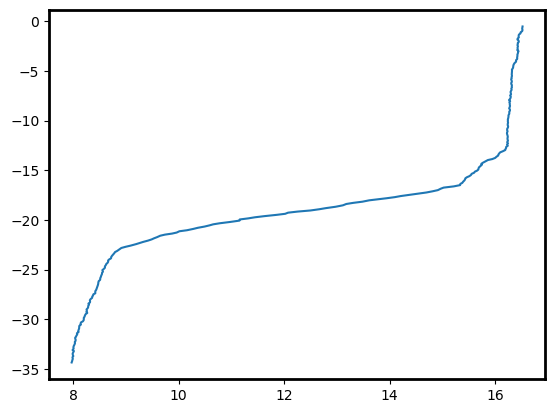

In [6]:
i = 11
df = D[i]

plt.plot(df["temperature"], -df["depth"])

In [ ]:
Pressure must not be right 

In [7]:
#df.drop(columns="date")
for c in df.columns:
    print(c, df[c].dtype)

conductivity float64
time datetime64[ns]
chloro-blue float64
dissolved oxygen float64
temperature float64
turbidity float64
tempdo float64
wipe float64
pressure float64
salinity float64
calcsv float64
density float64
depth float64
speed float64


In [8]:
cp_yml = "guerledan_202410.yaml"
cp = pin.Campaign(cp_yml)
cp

/Users/aponte/Code/pynsitu/pynsitu/events.py:48: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  self.time = pd.to_datetime(


Campaign(guerledan_202410 2024/10/08 to 2024/10/11)

In [9]:
df.lon, df.lat = sb.g_lon, sb.g_lat
#df["salinity"] = 0.

dfp = df.sw.compute_vertical_profile(0.5)
dsp = dfp.to_xarray()

# store
if True:
    nc = os.path.join(cp["path_processed"], "ctd.nc")
    dsp.to_netcdf(nc, mode="w")

some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values


/Users/aponte/Code/pynsitu/pynsitu/seawater.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.loc[:, "depth_cut"])


In [10]:
dsp

<xarray.Dataset> Size: 11kB
Dimensions:           (z: 68)
Coordinates:
  * z                 (z) float64 544B -0.25 -0.75 -1.25 ... -33.25 -33.75
Data variables: (12/19)
    conductivity      (z) float64 544B 0.1266 0.1266 0.1263 ... 0.1008 0.101 0.1
    time              (z) datetime64[ns] 544B 2024-10-07T01:30:05.320000 ... ...
    chloro-blue       (z) float64 544B 4.012 4.012 4.34 ... 3.26 3.282 3.243
    dissolved oxygen  (z) float64 544B 224.2 224.2 224.1 ... 42.16 32.63 25.3
    temperature       (z) float64 544B 16.52 16.52 16.47 ... 8.009 7.995 7.99
    turbidity         (z) float64 544B 1.216 1.216 1.545 ... 1.312 1.405 1.53
    ...                ...
    lon               (z) float64 544B 48.2 48.2 48.2 48.2 ... 48.2 48.2 48.2
    lat               (z) float64 544B -3.02 -3.02 -3.02 ... -3.02 -3.02 -3.02
    SA                (z) float64 544B 0.07174 0.07174 ... 0.07071 0.07013
    CT                (z) float64 544B 17.39 17.39 17.34 ... 8.455 8.441 8.435
    sigma0            (z) float64 544B -1.084 -1.084 ... -0.09191 -0.09207
    depth             (z) float64 544B 0.25 0.75 1.25 1.75 ... 32.75 33.25 33.75

/Users/aponte/.miniconda3/envs/insitu/lib/python3.10/site-packages/gsw/stability.py:86: RuntimeWarning: divide by zero encountered in divide
  N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))


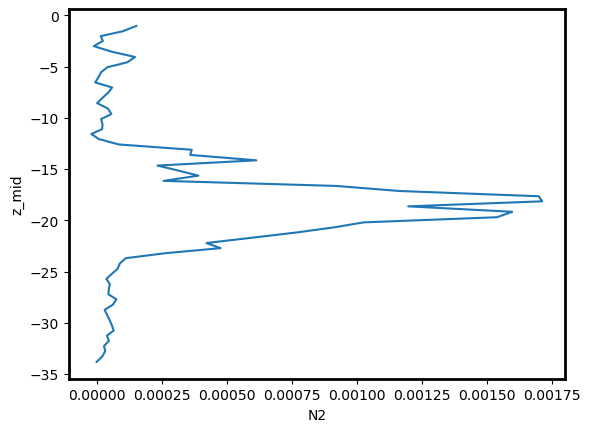

In [11]:
dsp.sw.set_vdim("z")
N2 = dsp.sw.N2

N2.plot(y="z_mid")

In [12]:
ds_vm, _ = vm.compute_vmodes(N2, N2.z_mid)

In [13]:
np.sqrt(35*10)

18.708286933869708

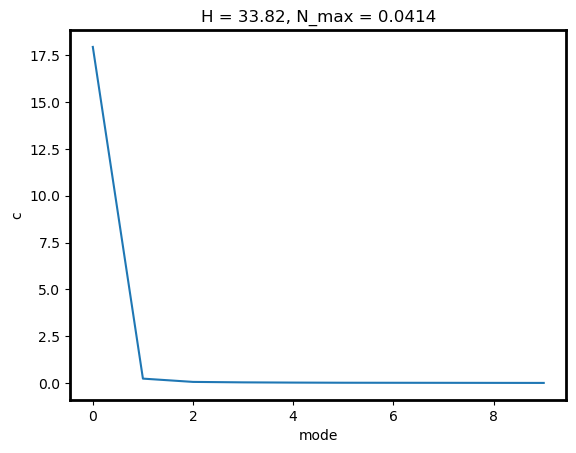

In [14]:
ds_vm.c.plot()

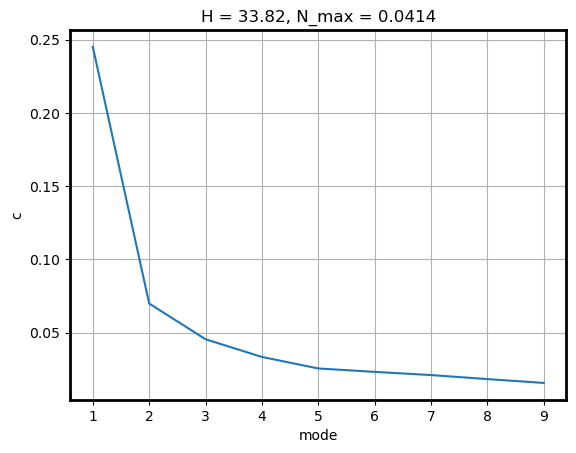

In [19]:
fig, ax = plt.subplots(1,1)
ds_vm.c.isel(mode=slice(1,None)).plot(ax=ax)
ax.grid()

In [37]:
# lake width
111e3*2e-3

222.0

Text(0.5, 1.0, '')

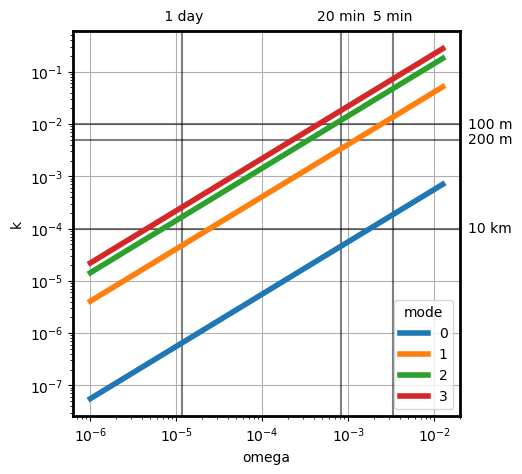

In [65]:
ds_vm["omega"] = ("omega", np.logspace(-6,-1.9))
ds_vm["omega_rad"] = ds_vm["omega"] * 2*np.pi
ds_vm["k"] = ds_vm["omega"] / ds_vm["c"]

fig, ax = plt.subplots(1,1, figsize=(5,5))
ds_vm["k"].isel(mode=slice(0,4)).plot.line(x="omega", hue="mode", zorder=10, linewidth=4)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()

def add_refs(ax, references, direction, off=.02, **kwargs):
    dkwargs = dict(color="k")
    dkwargs.update(**kwargs)
    for key, value in references.items():
        if direction=="h":
            ax.axhline(value, **dkwargs)
            ax.text(
                1+off, value, key, 
                transform=ax.get_yaxis_transform(),
                ha='left', va='center',
            )
        elif direction=="v":
            ax.axvline(value, **dkwargs)
            ax.text(
                value, 1+off, key, 
                transform=ax.get_xaxis_transform(),
                ha='center', va='bottom',
            )
    
add_refs(
    ax, 
    {" 1 day": 1/86400, "20 min": 1/20/60, "5 min": 1/5/60}, 
    "v", alpha=.5,
)
add_refs(
    ax, 
    {"10 km": 1/10e3, "200 m": 1/200, "100 m": 1/100}, 
    "h", 
    alpha=.5,
)

ax.set_title("")

In [33]:
1/86400

1.1574074074074073e-05

In [21]:
ds_vm

<xarray.Dataset> Size: 13kB
Dimensions:  (z: 66, mode: 10, omega: 50)
Coordinates:
  * z        (z) float64 528B -33.82 -33.3 -32.78 ... -2.025 -1.548 -1.028
    U        (z) float64 528B 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rho0     (z) float64 528B 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    N2       (z) float64 528B -2.711e-06 1.866e-05 ... 9.837e-05 0.0001502
    H        float64 8B 33.82
    N_max    float64 8B 0.0414
  * mode     (mode) int64 80B 0 1 2 3 4 5 6 7 8 9
  * omega    (omega) float64 400B 0.001 0.001099 0.001207 ... 0.09103 0.1
Data variables:
    phi      (z, mode) float64 5kB -0.0 0.0 0.0 ... 5.262e-06 -6.712e-06
    c        (mode) float64 80B 17.94 0.2451 0.06987 ... 0.02101 0.01826 0.01564
    dphidz   (z, mode) float64 5kB 0.0305 0.075 -0.1004 ... 0.1548 -0.2691